In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import pandas as pd
import numpy as np

## Загружаем данные

In [3]:
data_dir = 'data'

In [4]:
qid_query = pd.read_csv(f"{data_dir}/hidden_task/qid_query.tsv", 
                        sep="\t", 
                        names=["qid", "query"])
qid_url_rating = pd.read_csv(f"{data_dir}/hidden_task/qid_url_rating.tsv", 
                             sep="\t", 
                             names=["qid", "url", "rating"])
hostid_url = pd.read_csv(f"{data_dir}/hidden_task/hostid_url.tsv", 
                         sep="\t", 
                         names=["hostid", "url"])

Мерджим таблицы, чтобы было проще брать url с максимальным рейнтингом

In [5]:
qid_url_rating_hostid = pd.merge(qid_url_rating, hostid_url, on="url")
qid_url_rating_hostid.head()

,qid,url,rating,hostid
0,402111,http://24-job.com/board/job_australia/232-1-2-...,0.07,7
1,402111,http://24-job.com/board/job_australia/232-1-2-...,0.07,7
2,402111,http://802351.info/5964-v-avstralii.html,0.00,13
3,402111,http://auscommunity.com/blog/jobs/,0.00,53
4,402111,http://auscommunity.com/tag/%D1%84%D0%BE%D1%82...,0.00,53


## Имплементация подсчёта метрики PFound с примера

In [6]:
def plook(ind, rels):
    if ind == 0:
        return 1
    return plook(ind-1, rels)*(1-rels[ind-1])*(1-0.15)


def pfound(group, k: int = 10):
    max_by_host = group.groupby("hostid")["rating"].max() # максимальный рейтинг хоста
    top10 = max_by_host.sort_values(ascending=False)[:k] # берем топ10 урлов с наивысшим рейтингом
    pfound = 0
    for ind, val in enumerate(top10):
        pfound += val*plook(ind, top10.values)
    return pfound

Проверим его работу

In [7]:
qid_pfound = qid_url_rating_hostid.groupby('qid').apply(pfound) # группируем по qid и вычисляем pfound
qid_max = qid_pfound.idxmax() # берем qid с максимальным pfound

qid_query[qid_query["qid"] == qid_max]

,qid,query
14,692308,бесплатный просмотр камеди клаб


На основании этой реализации, напишем функцию, которая возвращает средний pFound по всем query

In [8]:
def mean_pfound_yandex(qid_url_rating_hostid: pd.DataFrame) -> float:
    qid_pfound = qid_url_rating_hostid.groupby('qid').apply(pfound)
    return qid_pfound.mean()

In [9]:
print(f'Средний PFound по всем query: {mean_pfound_yandex(qid_url_rating_hostid)}')

Средний PFound по всем query: 0.5822199638393889


А также проверим скорость выполнения данной реализации

In [10]:
%%timeit
mean_pfound_yandex(qid_url_rating_hostid)

10.4 ms ± 137 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Реализуем свою версию метрики PFound без использования циклов

In [11]:
qid_url_rating_hostid = pd.merge(qid_url_rating, hostid_url, on="url")

Сгруппируем датасет таким образом, чтобы для каждого запроса оставить только одну ссылку с максимальным рейнтингом

In [12]:
%%time
max_rate_by_qid_hostid = qid_url_rating_hostid[['qid', 'rating', 'hostid']]
max_rate_by_qid_hostid = max_rate_by_qid_hostid.groupby(['qid', 'hostid']).max()

CPU times: user 2.38 ms, sys: 0 ns, total: 2.38 ms
Wall time: 2.2 ms


Далее отсортируем рейнтинг каждой ссылки по возрастанию внутри каждого запроса, чтобы использовать полученный датасет для определения топа рекомендаций

In [13]:
%%time
max_rate_by_qid_hostid = max_rate_by_qid_hostid.sort_values(['qid', 'rating'], ascending=False)
max_rate_by_qid_hostid['top'] = max_rate_by_qid_hostid.groupby('qid').cumcount() + 1
max_rate_by_qid_hostid

CPU times: user 2.24 ms, sys: 0 ns, total: 2.24 ms
Wall time: 2.02 ms


rating  top
qid    hostid             
692308 1035      0.61    1
       551       0.41    2
       1155      0.41    3
       33        0.14    4
       70        0.14    5
...               ...  ...
5308   734       0.00   18
       767       0.00   19
       866       0.00   20
       1050      0.00   21
       1097      0.00   22

[607 rows x 2 columns]

Отфильтруем те значения из рекомендаций, который не входят в TopK

In [14]:
k = 10

In [15]:
%%time
topk_recs_for_qid = max_rate_by_qid_hostid[max_rate_by_qid_hostid['top'] <= k]
topk_recs_for_qid = topk_recs_for_qid.reset_index()

CPU times: user 0 ns, sys: 1.57 ms, total: 1.57 ms
Wall time: 1.36 ms


Добавим переменные для расчета согласно формуле


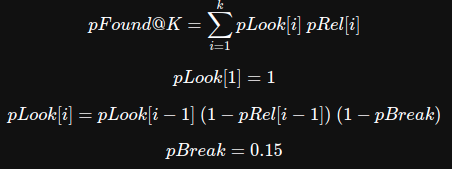

In [16]:
p_break = 0.15

Так как в формуле показатель релевантности используется со смещением, сделаем его:

In [17]:
%%time
topk_recs_for_qid['pReilShift1'] = topk_recs_for_qid['rating'].shift(1)

CPU times: user 536 µs, sys: 0 ns, total: 536 µs
Wall time: 527 µs


Рассчитаем множитель перед Plook с участием pReil:

In [18]:
%%time
topk_recs_for_qid['pLookMulti'] = (1 - topk_recs_for_qid['pReilShift1']) * (1 - p_break)

CPU times: user 568 µs, sys: 54 µs, total: 622 µs
Wall time: 616 µs


Так как по условию pLook[1]=1:

In [19]:
%%time
topk_recs_for_qid.loc[(topk_recs_for_qid['top'] == 1), 'pLookMulti'] = 1

CPU times: user 0 ns, sys: 470 µs, total: 470 µs
Wall time: 473 µs


Так как в значение каждого pLook[i] участвуе pLook[i - 1] в качестве множителя, то воспользуемся накапливаемым произведением, чтобы это учесть для значений заранее посчитанного нами множителя, сгруппировав по qid

In [20]:
%%time
topk_recs_for_qid['pLook'] = topk_recs_for_qid.groupby('qid')['pLookMulti'].cumprod()

CPU times: user 847 µs, sys: 80 µs, total: 927 µs
Wall time: 899 µs


Теперь рассчитаем произведение pLook[i] и pReil[i]

In [21]:
%%time
topk_recs_for_qid['pFound'] = topk_recs_for_qid['pLook'] * topk_recs_for_qid['rating']
topk_recs_for_qid.head(2*k - 1)

CPU times: user 621 µs, sys: 0 ns, total: 621 µs
Wall time: 613 µs


,qid,hostid,rating,top,pReilShift1,pLookMulti,pLook,pFound
0,692308,1035,0.61,1,NaN,1.0000,1.000000,0.610000
1,692308,551,0.41,2,0.61,0.3315,0.331500,0.135915
2,692308,1155,0.41,3,0.41,0.5015,0.166247,0.068161
3,692308,33,0.14,4,0.41,0.5015,0.083373,0.011672
4,692308,70,0.14,5,0.14,0.7310,0.060946,0.008532
5,692308,259,0.14,6,0.14,0.7310,0.044551,0.006237
6,692308,392,0.14,7,0.14,0.7310,0.032567,0.004559
7,692308,393,0.14,8,0.14,0.7310,0.023806,0.003333
8,692308,617,0.14,9,0.14,0.7310,0.017403,0.002436
9,692308,622,0.14,10,0.14,0.7310,0.012721,0.001781


Далее проссумируем их, чтобы посчитать метрику pFound для каждого запроса

In [22]:
%%time
p_found_by_qid = topk_recs_for_qid.groupby(['qid']).sum()['pFound']

CPU times: user 1.68 ms, sys: 0 ns, total: 1.68 ms
Wall time: 1.53 ms


Проверим правильность работы алгоритма

In [23]:
%%time
qid_max = p_found_by_qid.idxmax() # берем qid с максимальным pfound
qid_query[qid_query["qid"] == qid_max]

CPU times: user 436 µs, sys: 0 ns, total: 436 µs
Wall time: 425 µs


,qid,query
14,692308,бесплатный просмотр камеди клаб


In [24]:
%%time
p_found_by_qid.mean()

CPU times: user 104 µs, sys: 0 ns, total: 104 µs
Wall time: 106 µs


0.5822199638393889

Оформим данное решение в виде функции, которая на вход принимает значение датафрейма после merge и возвращает средний pFound по все выборке

In [25]:
def mean_pfound_ours(df: pd.DataFrame, k: int, p_break: float) -> float:
    max_rate_by_qid_hostid = df[['qid', 'rating', 'hostid']]
    max_rate_by_qid_hostid = max_rate_by_qid_hostid.groupby(['qid', 'hostid']).max()
    
    max_rate_by_qid_hostid = max_rate_by_qid_hostid.sort_values(['qid', 'rating'], 
                                                                ascending=False)
    
    max_rate_by_qid_hostid['top'] = max_rate_by_qid_hostid.groupby('qid').cumcount() + 1
    topk_recs_for_qid = max_rate_by_qid_hostid[max_rate_by_qid_hostid['top'] <= k]
    topk_recs_for_qid = topk_recs_for_qid.reset_index()
    
    topk_recs_for_qid['pReilShift1'] = topk_recs_for_qid['rating'].shift(1)
    
    topk_recs_for_qid['pLookMulti'] = (1 - topk_recs_for_qid['pReilShift1']) * (1 - p_break)
    topk_recs_for_qid.loc[(topk_recs_for_qid['top'] == 1), 'pLookMulti'] = 1
    topk_recs_for_qid['pLook'] = topk_recs_for_qid.groupby('qid')['pLookMulti'].cumprod()
    topk_recs_for_qid['pFound'] = topk_recs_for_qid['pLook'] * topk_recs_for_qid['rating']
    topk_recs_for_qid = topk_recs_for_qid.reset_index().drop(['pLook', 
                                                              'pLookMulti', 
                                                              'pReilShift1',
                                                              'top'], axis=1)
    return topk_recs_for_qid.groupby(['qid']).sum()['pFound'].mean()
    

Проверим скорость работы

In [26]:
%%timeit
mean_pfound_ours(qid_url_rating_hostid, 10, 0.15)

5.87 ms ± 25.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [27]:
%%timeit
mean_pfound_yandex(qid_url_rating_hostid)

10.4 ms ± 25 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Как мы видим реализация без циклов оказалась в 2 раза быстре, что говорит о том, что работа была проделана не зря :)